In [1]:
% run 1-datasource.ipynb

In [2]:
% run 4-graph-utils.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
import scipy.sparse.csgraph
from tensorboardX import SummaryWriter
import skimage.transform as transform
import networkx as nx
from scipy import spatial

In [291]:
#from pygsp.reduction import graph_sparsify#, kron_reduction
from pygsp import graphs, filters, utils
from scipy.sparse.linalg import eigsh
from scipy.sparse import linalg
from scipy import sparse, stats
from scipy.sparse.csgraph import minimum_spanning_tree, dijkstra

In [5]:
from pyamg import smoothed_aggregation_solver

In [7]:
icebergs.head()

,band_1,band_2,inc_angle,is_iceberg
id,,,,
dfd5f913,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
e25388fd,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


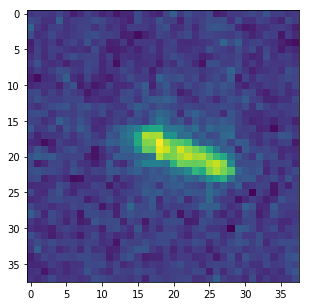

In [8]:
test = transform.rescale(icebergs.band_1.iloc[100].reshape(75, 75), 0.5, mode='constant')
plt.imshow(test);

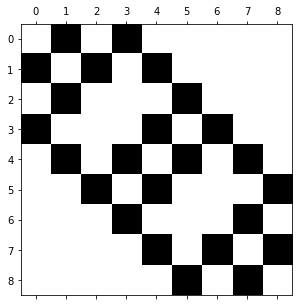

In [9]:
plt.spy(distance(grid(3), k=1, metric='cityblock'));

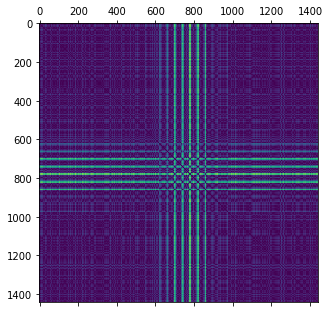

In [10]:
test_dist = spatial.distance.squareform(spatial.distance.pdist(test.reshape(-1, 1), metric='euclidean'))
plt.matshow(test_dist);

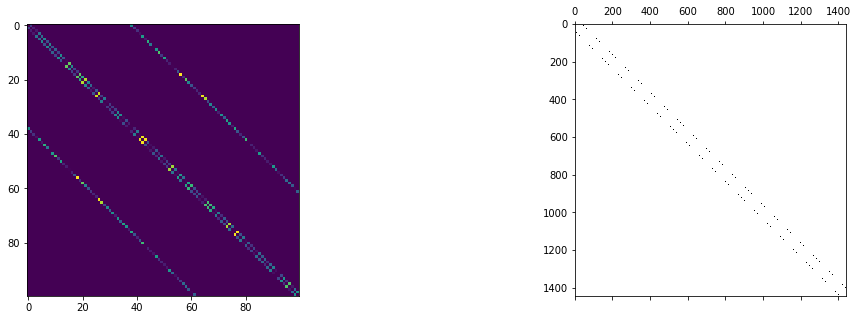

In [11]:
test_dist[np.where(distance(grid(38), k=2) == 0)] = 0

plt.subplot(121)
plt.imshow(test_dist[:100, :100])

plt.subplot(122)
plt.spy(test_dist);

In [278]:
def calc_weight(n, root):
    
    if n==root:
        return 0, root
    
    parent = pred[root, n]

    w_p = local_tree[parent, n]
    
    gparent = pred[root, parent]
    
    if gparent != -9999:
        w_d = local_tree[gparent, parent]
    else:
        w_d = 1
        gparent = n
        
    w = 2./(1./w_p + 1./w_d)

    return w, gparent

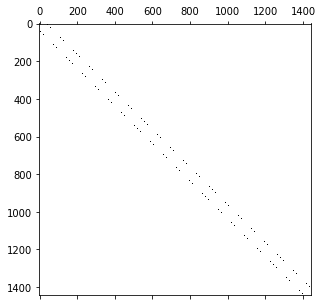

In [196]:
plt.spy(test_dist)

In [266]:
local_tree[:5, :5]

matrix([[ 0.        ,  1.07886739,  0.        ,  0.        ,  0.        ],
        [ 1.07886739,  0.        ,  0.50027652,  0.        ,  0.        ],
        [ 0.        ,  0.50027652,  0.        ,  0.39578358,  0.        ],
        [ 0.        ,  0.        ,  0.39578358,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [272]:
even_nodes.shape

(722,)

In [263]:
pred[root, 43]

81

In [230]:
test_dist_triu = np.triu(test_dist)

In [279]:
Tree = minimum_spanning_tree(test_dist_triu)
Tree = Tree + Tree.T

distance_matrix, pred = dijkstra(Tree.todense(), directed=False, unweighted=True, return_predecessors=True)

root = np.random.choice(np.arange(distance_matrix.shape[0]))
even_nodes = distance_matrix[:, root] % 2 == 0
even_nodes = np.arange(1444)[even_nodes]


"""for i in range(distance_matrix_even.shape[0]):
    if distance_matrix[i, root] % 2 != 0:
        distance_matrix_even[i, :] = 0
        distance_matrix_even[:, i] = 0
"""
"""
distance_from_root = np.zeros(distance_matrix.shape)
distance_from_root[root,:] = distance_matrix[root,:]
distance_from_root[:,root] = distance_matrix[:,root]
                        
even_distance = distance_from_root
even_distance[even_distance % 2 != 0] = 0
"""

"""local_tree = Tree.todense()

dist_index = distance_matrix_even.nonzero()#even_distance.nonzero()

weights_ind = list(zip(dist_index[0], dist_index[1]))


"""
weight_tree = np.zeros(local_tree.shape)

for n in even_nodes:
    print("node : ",n)
    out = calc_weight(n, root)
    print("out : ", out)
    weight_tree[n, out[1]] = out[0]
    weight_tree[out[1], n] = out[0]


node :  1
out :  (0.44193738968619645, 3)
node :  3
out :  (0.17145013360529726, 40)
node :  5
out :  (0.050116681859210255, 81)
node :  7
out :  (0.60103484682826169, 46)
node :  9
out :  (0.032607083746760211, 46)
node :  11
out :  (0.49172991504369856, 50)
node :  13
out :  (0.77258860105578631, 50)
node :  15
out :  (0.088600767392440272, 91)
node :  17
out :  (0.71753282345424985, 54)
node :  19
out :  (1.0174570205000253, 95)
node :  21
out :  (1.9402793534717466, 97)
node :  23
out :  (0.4458743596819229, 62)
node :  25
out :  (0.46913726576157483, 101)
node :  27
out :  (0.20504597247540007, 29)
node :  29
out :  (0.92486723664121928, 31)
node :  31
out :  (0.64580588906809422, 70)
node :  33
out :  (0.79761875824579009, 70)
node :  35
out :  (0.29378591703832246, 72)
node :  37
out :  (0.65843425049128923, 35)
node :  38
out :  (0.74741853794549229, 1)
node :  40
out :  (0.79793382502037469, 116)
node :  42
out :  (2.415928506769176, 5)
node :  44
out :  (0.24127517122949113, 

node :  1106
out :  (0.35519676972219622, 1145)
node :  1108
out :  (0.30054850593399507, 1145)
node :  1110
out :  (0.88786555104874865, 1147)
node :  1112
out :  (0.44616113690564041, 1075)
node :  1114
out :  (0.1294749982917795, 1075)
node :  1116
out :  (1.2264496175052471, 1079)
node :  1118
out :  (1.649767700607067, 1194)
node :  1120
out :  (0.46597403063592269, 1157)
node :  1122
out :  (0.29471659319379534, 1159)
node :  1124
out :  (1.3183625890914406, 1161)
node :  1126
out :  (0.67773562465025039, 1163)
node :  1128
out :  (0.94585279011902679, 1126)
node :  1130
out :  (1.1676737316737209, 1054)
node :  1132
out :  (0.075032125509742434, 1171)
node :  1134
out :  (0.8499129839355356, 1173)
node :  1136
out :  (0.38296918675685759, 1173)
node :  1138
out :  (1.1155882349563662, 1099)
node :  1141
out :  (0.45950738693352627, 1104)
node :  1143
out :  (1.0358734000567178, 1104)
node :  1145
out :  (1.2091711980921638, 1221)
node :  1147
out :  (0.80937775964172365, 1145)
n

In [280]:
root

294

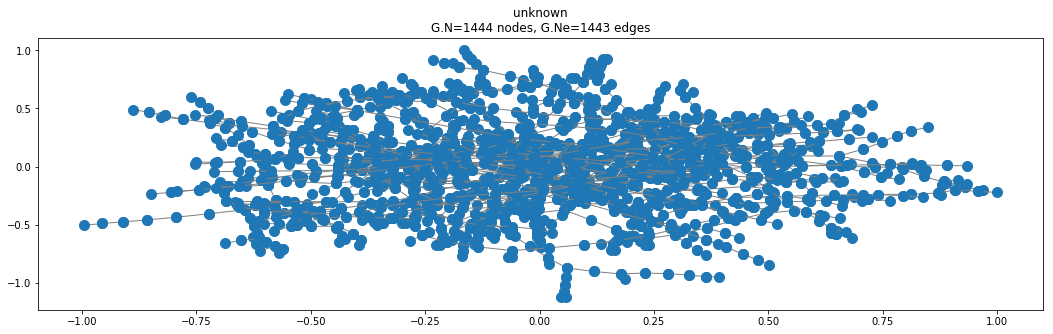

In [288]:
G = graphs.Graph(Tree)
G.set_coordinates()
G.plot()

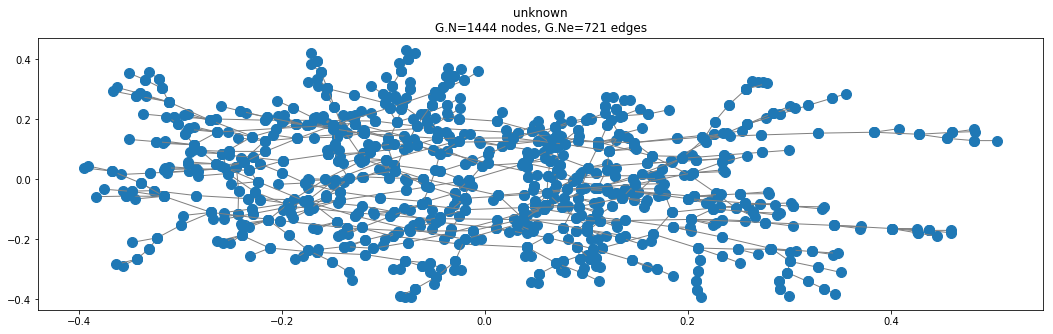

In [289]:
G2 = graphs.Graph(weight_tree)
G2.set_coordinates()
G2.plot()

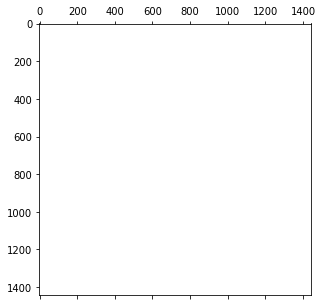

In [52]:
plt.spy(weight_tree)

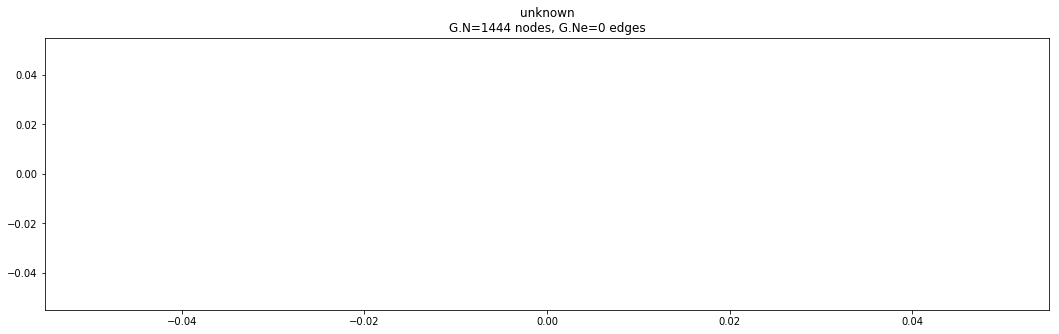

In [53]:
G1 = graphs.Graph(weight_tree)
G1.set_coordinates()
G1.plot()

In [ ]:
G = sp.sparse.csr.csr_matrix(distance(grid(4), 1, metric='cityblock'))

In [ ]:
plt.spy(G.todense())

In [ ]:
graph, perm = coarsen(G, levels=2, self_connections=False)

In [ ]:
perm

In [ ]:
for g in graph:
    plt.subplot(121)
    plt.spy(g.todense())
    plt.subplot(122)
    nx.draw(nx.from_numpy_array(g.todense()))
    plt.show()

In [ ]:
gr = grid(38)
gr.shape

In [ ]:
mask = distance(gr, k=3) > 0
plt.spy(mask[:40, :40]);

In [ ]:
graph, perm = coarsen(sp.sparse.csr.csr_matrix(mask), levels=3, self_connections=False)